# Podsumowanie mini projektu

### Najważniejsze pomysły
- Podział na zbiór treningowy i testowy
- Adam vs SGD jako optymalizator
- ReLU/LeakyRelU na wyjściu (nigdy nie chcemy przewidywać ujemnej liczby wypożyczeń)
- Model z kilkoma warstwami, długie trenowanie
- Skalowanie wejść/wyjść - uwaga obliczamy skalowanie (np. min/max czy mean/std na zbiorze treningowym i **te same** wartości stosujemy na zbiorze testowym

In [2]:
import torch, torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
import numpy as np
import pandas as pd
import torch.utils.data as data
import seaborn as sns
import matplotlib.pyplot as plt

## Skalowanie wyjść wewnątrz sieci - batch norm
Batch-Normalization is an algorithmic method which makes the training of Deep Neural Networks (DNN) faster and more stable.  
visualisation:  
- No BN: https://miro.medium.com/v2/resize:fit:1400/format:webp/1*tcvRJN-OadhUyps6HSO0og.jpeg   
- BN: https://miro.medium.com/v2/resize:fit:1400/format:webp/1*QcSkw489NgtpaMuwDhehaQ.jpeg  

BN inaczej zachowuje się w train() i eval().

Na przykładzie z mini projektu


In [5]:
train_data = pd.read_csv("data.csv",index_col=0)

In [6]:
train = train_data.drop(columns=["casual","registered","cnt","dteday","season","yr","mnth"])
train_dataset = data.TensorDataset(torch.from_numpy(train.values).float(),torch.from_numpy(train_data.values[:,-1].astype(float)).float())

In [7]:
data_loader  = data.DataLoader(train_dataset, batch_size=256, shuffle=True)

In [8]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.lin1 =nn.Linear(9, 48)  # 28 x 28 = 784
        self.act1 =nn.ReLU()
        self.lin2 =nn.Linear(48, 24)
        self.act2 =nn.ReLU()
        self.lin3 =nn.Linear(24, 1)


    def forward(self, x):
        x = self.lin1(x)
        x = self.act1(x)
        x = self.lin2(x)
        x = self.act2(x)
        x = self.lin3(x)
        return x

In [9]:
class MyNetBN(nn.Module):
    def __init__(self):
        super(MyNetBN, self).__init__()
        self.lin1 =nn.Linear(9, 48)  # 28 x 28 = 784
        self.bn1 = nn.BatchNorm1d(48)
        self.act1 =nn.ReLU()
        self.lin2 =nn.Linear(48, 24)
        self.bn2 = nn.BatchNorm1d(24)
        self.act2 =nn.ReLU()
        self.lin3 =nn.Linear(24, 1)


    def forward(self, x):
        x = self.lin1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.lin2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.lin3(x)
        return x

In [10]:
model = MyNet()
print(model)

MyNet(
  (lin1): Linear(in_features=9, out_features=48, bias=True)
  (act1): ReLU()
  (lin2): Linear(in_features=48, out_features=24, bias=True)
  (act2): ReLU()
  (lin3): Linear(in_features=24, out_features=1, bias=True)
)


In [11]:
model_bn = MyNetBN()
print(model_bn)

MyNetBN(
  (lin1): Linear(in_features=9, out_features=48, bias=True)
  (bn1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (lin2): Linear(in_features=48, out_features=24, bias=True)
  (bn2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (lin3): Linear(in_features=24, out_features=1, bias=True)
)


In [12]:
loss_fn = nn.MSELoss()
opt = optim.SGD(model.parameters(), lr=0.0001, momentum=0.5)
opt_bn = optim.SGD(model_bn.parameters(), lr=0.0001, momentum=0.5)

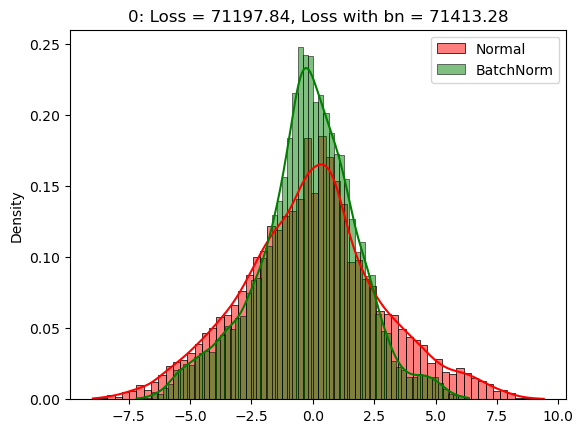

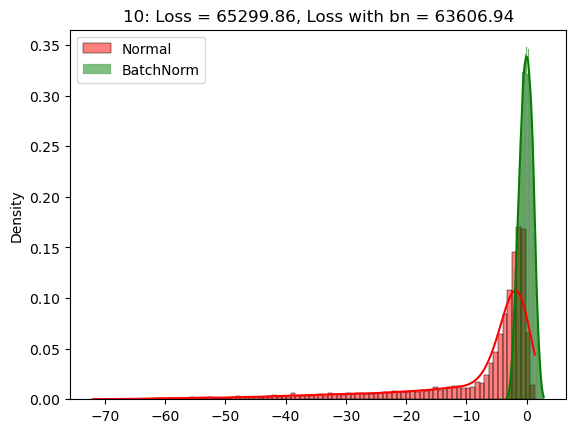

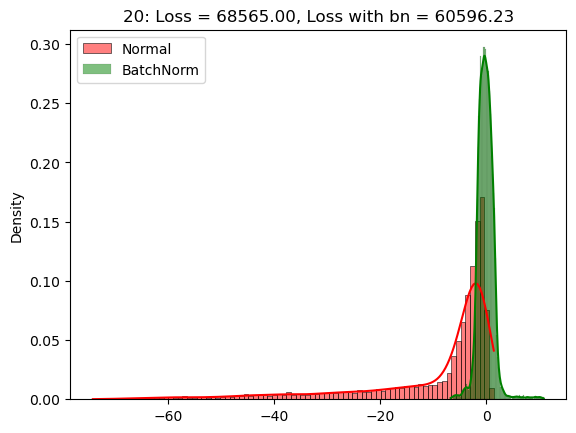

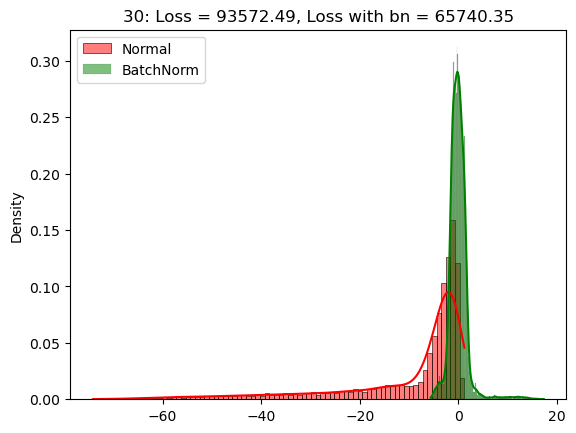

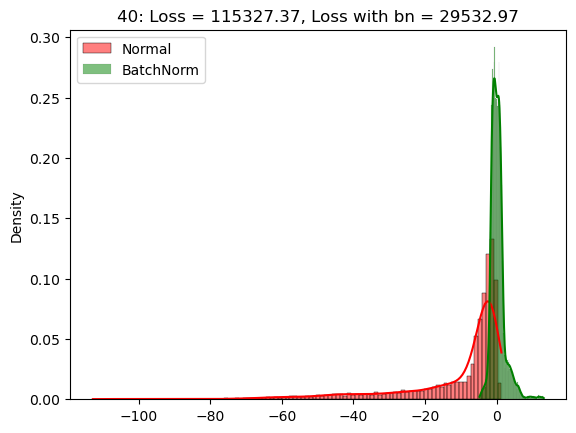

----------------------


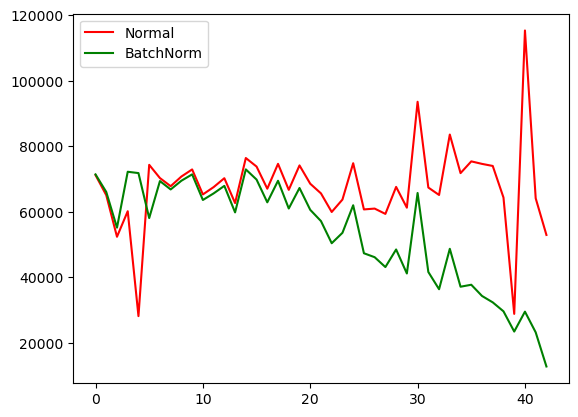

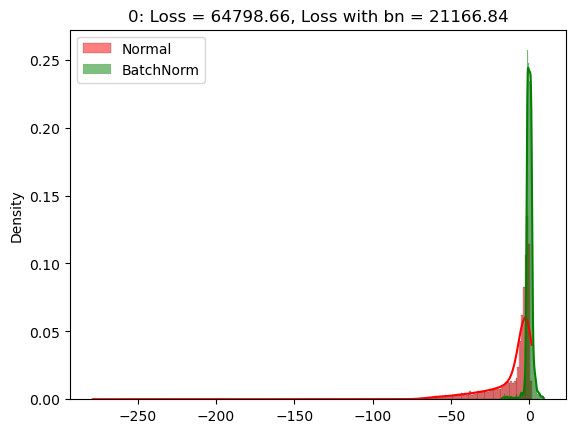

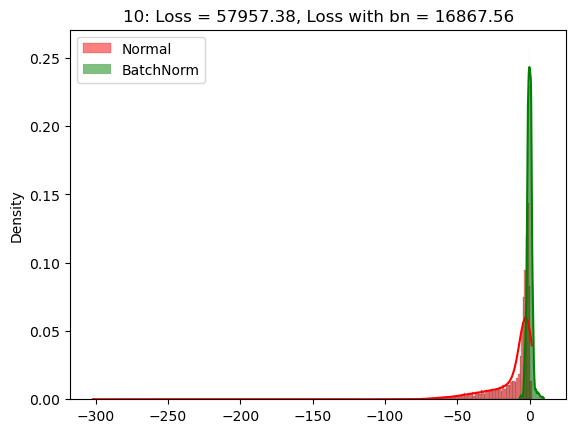

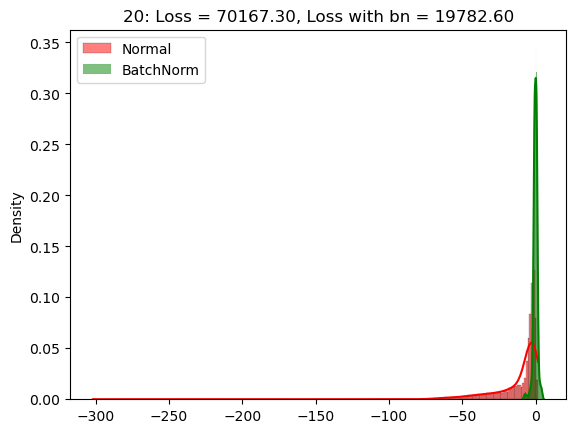

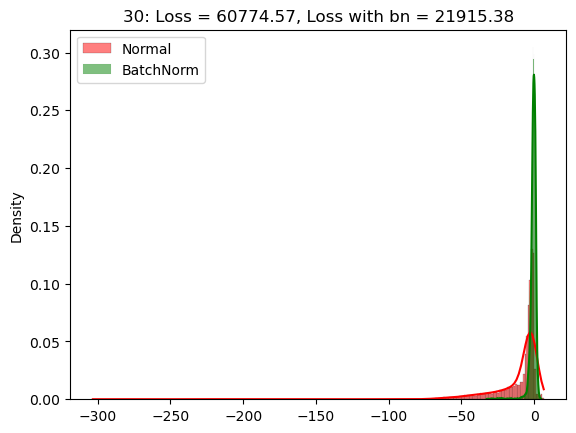

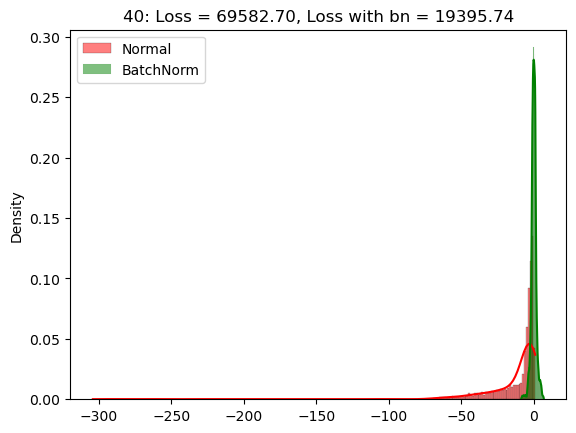

----------------------


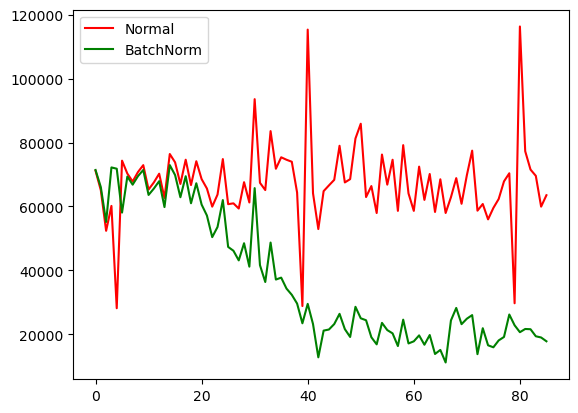

In [13]:
loss_arr = []
loss_bn_arr = []

max_epochs = 2

for epoch in range(max_epochs):
    for i, batch in enumerate(data_loader, 0):

        inputs, labels = batch

        # training steps for normal model
        opt.zero_grad()
        outputs = model(inputs).squeeze()
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

        # training steps for bn model
        opt_bn.zero_grad()
        outputs_bn = model_bn(inputs).squeeze()
        loss_bn = loss_fn(outputs_bn, labels)
        loss_bn.backward()
        opt_bn.step()

        loss_arr.append(loss.item())
        loss_bn_arr.append(loss_bn.item())

        if i % 10 == 0:

            inputs = inputs.view(inputs.size(0), -1)

            model.eval()
            model_bn.eval()

            a = model.lin1(inputs)
            a = a.detach().numpy().ravel()
            sns.histplot(a, kde=True, color='r', label='Normal', stat="density")

            b = model_bn.lin1(inputs)
            b = model_bn.bn1(b)
            b = b.detach().numpy().ravel()

            sns.histplot(b, kde=True, color='g', label='BatchNorm', stat="density")
            plt.title('%d: Loss = %0.2f, Loss with bn = %0.2f' % (i, loss.item(), loss_bn.item()))
            plt.legend()
            plt.show()
            plt.pause(0.5)

            model.train()
            model_bn.train()


    print('----------------------')

    plt.plot(loss_arr, 'r', label='Normal')
    plt.plot(loss_bn_arr, 'g', label='BatchNorm')
    plt.legend()
    plt.show()

## Przeuczanie sieci

In [14]:
mnist_data = torchvision.datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)
mnist_train = mnist_data[:20]
mnist_val   = mnist_data[20:1000]

Failed to download (trying next):
HTTP Error 404: Not Found



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [21]:
device = torch.device("cpu") #MY MAC CANT GPU
device

device(type='cpu')

In [22]:
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

In [23]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 800)
        self.act_1 =  nn.Tanh()
        self.layer2 = nn.Linear(800, 800)
        self.act_2 = nn.Tanh()
        self.layer3 = nn.Linear(800, 10)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = self.act_1(self.layer1(flattened))
        activation2 = self.act_2(self.layer2(activation1))
        output = self.layer3(activation2)
        return output

In [24]:
def train(model, train, valid, batch_size=10, num_epochs=1, learn_rate=0.001, weight_decay=0):
    train_loader = torch.utils.data.DataLoader(train,
                                               batch_size=batch_size,
                                               shuffle=True) # shuffle after every epoch
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learn_rate,momentum=0.9, weight_decay=weight_decay)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
#     n = 0 # the number of iterations
    idx = 0
    for n in range(num_epochs):
        for imgs, labels in iter(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            model.train()
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()

            # save the current training information
            if idx % 10 == 9:
                iters.append(idx)
                losses.append(float(loss)/batch_size)        # compute *average* loss
                train_acc.append(get_accuracy(model, train)) # compute training accuracy
                val_acc.append(get_accuracy(model, valid))   # compute validation accuracy
            idx+=1
        if n%100==0:
            print(f"Epoch {n}")


    # plotting
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()


    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


train_acc_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100)
val_acc_loader = torch.utils.data.DataLoader(mnist_val, batch_size=1000)

def get_accuracy(model, data):
    correct = 0
    total = 0
    model.eval() #*********#
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        imgs, labels = imgs.to(device), labels.to(device)
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


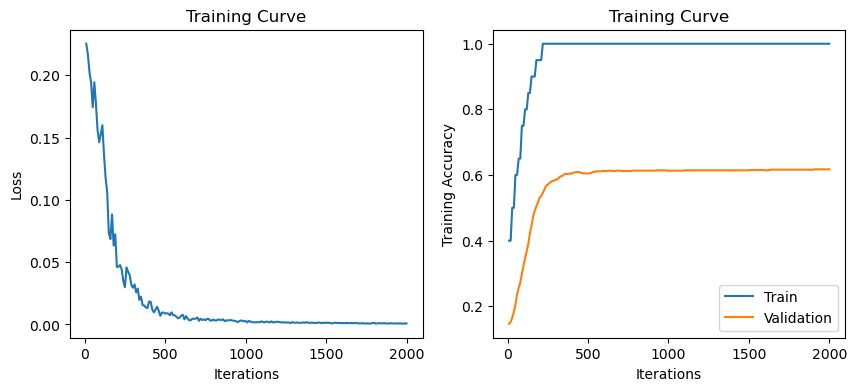

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.6173469387755102


In [26]:
model = MNISTClassifier().to(device)
train(model, mnist_train, mnist_val, num_epochs=1000)

## Dropout
Maskowanie losowych neuronów w sieci.
Dropout inaczej się w train() i eval().

In [27]:
class MNISTClassifier_Dropout(nn.Module):
    def __init__(self):
        super(MNISTClassifier_Dropout, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 800)
        self.d1 = nn.Dropout(0.6)
        self.act_1 =  nn.Tanh()
        self.layer2 = nn.Linear(800, 800)
        self.d2 = nn.Dropout(0.6)
        self.act_2 = nn.Tanh()
        self.layer3 = nn.Linear(800, 10)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = self.act_1(self.layer1(flattened))
        x = self.d1(activation1)
        activation2 = self.act_2(self.layer2(x))
        x = self.d2(activation2)
        output = self.layer3(x)
        return output

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


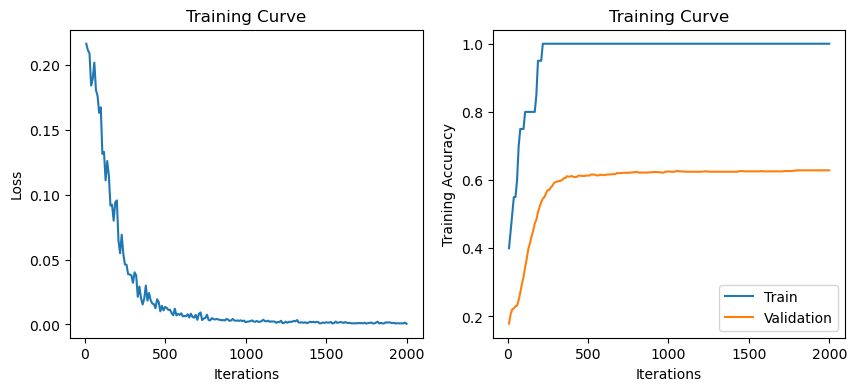

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.6285714285714286


In [28]:
model = MNISTClassifier_Dropout().to(device)
train(model, mnist_train, mnist_val, num_epochs=1000)

## Weight decay
Regularyzacja zmian wag

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


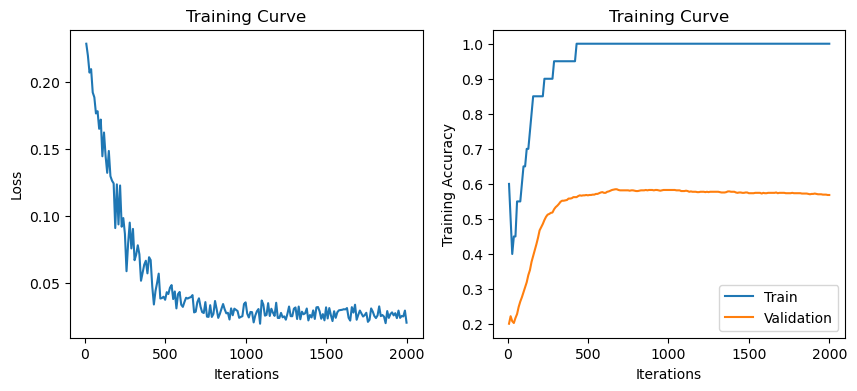

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5683673469387756


In [29]:
model = MNISTClassifier().to(device)
train(model, mnist_train, mnist_val, num_epochs=1000, weight_decay=0.1)

## Zadanie - własna regularyzacja

In [30]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 800)
        self.act_1 =  nn.Tanh()
        self.layer2 = nn.Linear(800, 800)
        self.act_2 = nn.Tanh()
        self.layer3 = nn.Linear(800, 10)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = self.act_1(self.layer1(flattened))
        activation2 = self.act_2(self.layer2(activation1))
        output = self.layer3(activation2)
        return output

In [31]:
model = MNISTClassifier().to(device)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=10, shuffle=True) # shuffle after every epoch
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


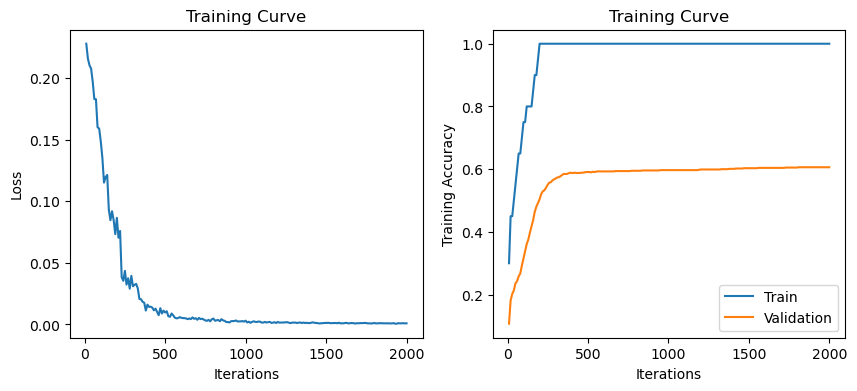

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.6061224489795919


In [32]:
iters, losses, train_acc, val_acc = [], [], [], []

idx = 0
for n in range(1000):
    for imgs, labels in iter(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        model.train()
        out = model(imgs)
        ######
        # Here propose some form of regularization
        # HINT model.layer1 or list(model.parameters())

        regularization = 0

        ######
        loss = criterion(out, labels) + regularization # compute the total loss as a sum of loss + regularization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


        if idx % 10 == 9:
            iters.append(idx)
            losses.append(float(loss)/10)        # compute *average* loss
            train_acc.append(get_accuracy(model, mnist_train)) # compute training accuracy
            val_acc.append(get_accuracy(model, mnist_val))   # compute validation accuracy
        idx+=1
    if n%100==0:
        print(f"Epoch {n}")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.title("Training Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()


print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))

# Wielkość sieci a jej jakość

In [33]:
class MNISTClassifier_parametrized(nn.Module):
    def __init__(self,size_1,size_2):
        super(MNISTClassifier_parametrized, self).__init__()
        self.layer1 = nn.Linear(28 * 28, size_1)
        self.act_1 =  nn.Tanh()
        self.layer2 = nn.Linear(size_1, size_2)
        self.act_2 = nn.Tanh()
        self.layer3 = nn.Linear(size_2, 10)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = self.act_1(self.layer1(flattened))
        activation2 = self.act_2(self.layer2(activation1))
        output = self.layer3(activation2)
        return output

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


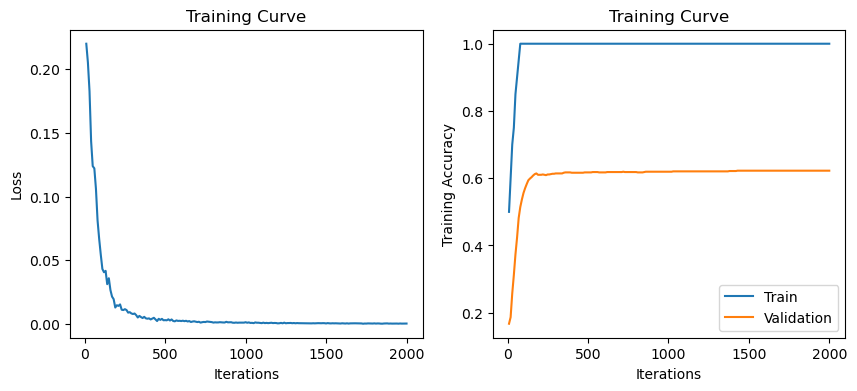

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.6224489795918368


In [34]:
model = MNISTClassifier_parametrized(5000,3000).to(device)
train(model, mnist_train, mnist_val, num_epochs=1000)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


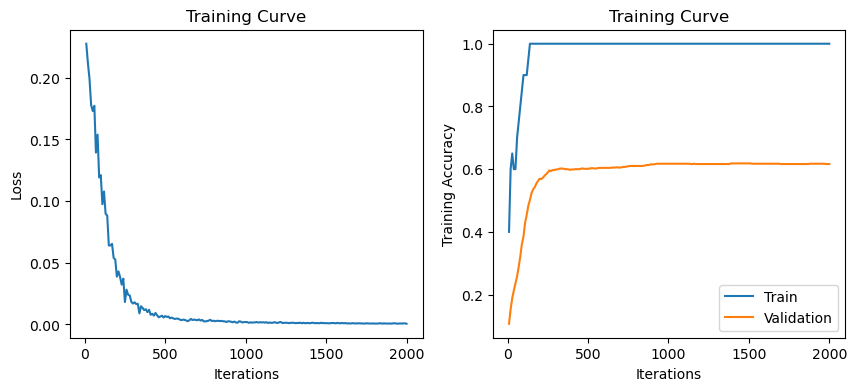

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.6163265306122448


In [35]:
model = MNISTClassifier_parametrized(2000,1000).to(device)
train(model, mnist_train, mnist_val, num_epochs=1000)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


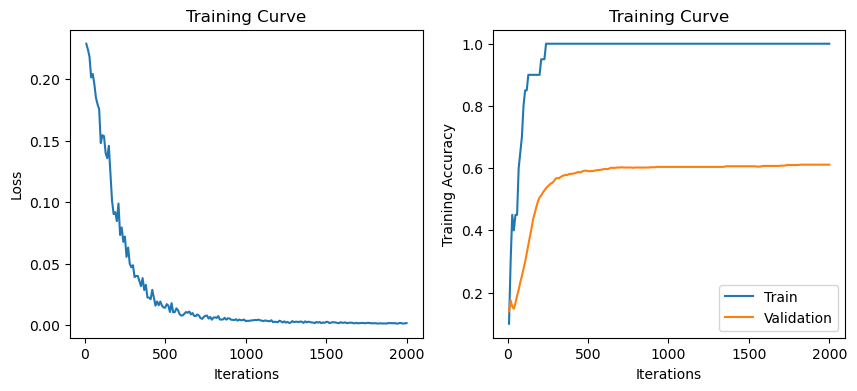

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.6112244897959184


In [36]:
model = MNISTClassifier_parametrized(1000,100).to(device)
train(model, mnist_train, mnist_val, num_epochs=1000)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


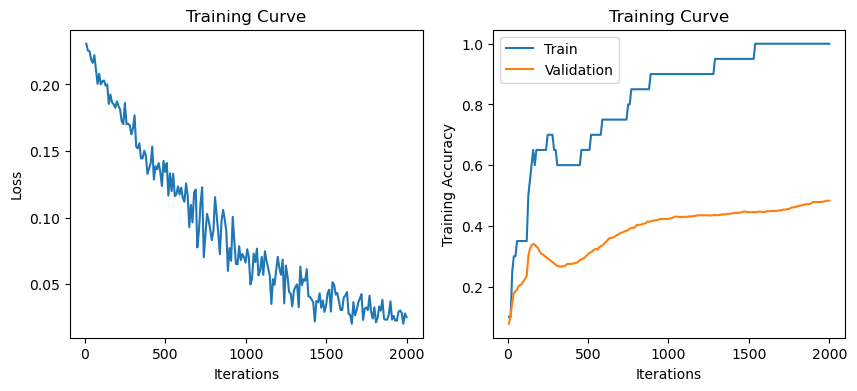

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.4826530612244898


In [37]:
model = MNISTClassifier_parametrized(20,10).to(device)
train(model, mnist_train, mnist_val, num_epochs=1000)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900
Epoch 2000
Epoch 2100
Epoch 2200
Epoch 2300
Epoch 2400
Epoch 2500
Epoch 2600
Epoch 2700
Epoch 2800
Epoch 2900
Epoch 3000
Epoch 3100
Epoch 3200
Epoch 3300
Epoch 3400
Epoch 3500
Epoch 3600
Epoch 3700
Epoch 3800
Epoch 3900
Epoch 4000
Epoch 4100
Epoch 4200
Epoch 4300
Epoch 4400
Epoch 4500
Epoch 4600
Epoch 4700
Epoch 4800
Epoch 4900


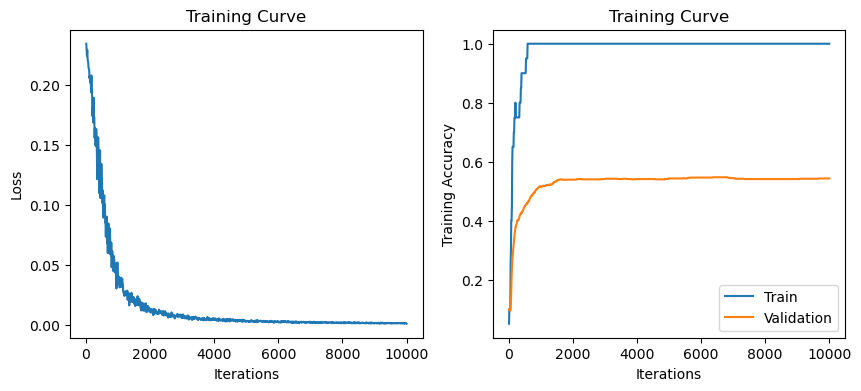

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5428571428571428


In [38]:
model = MNISTClassifier_parametrized(20,10).to(device)
train(model, mnist_train, mnist_val, num_epochs=5000)

In [39]:
def fast_accuracy(model, data):
    with torch.no_grad():
        correct = 0
        total = 0
        model.eval()
        imgs, labels = data
        output = model(imgs.to(device))
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred).to(device)).sum().item()
        total += imgs.shape[0]
    return correct / total

def train_search(model, train, valid, batch_size=10, num_epochs=1, learn_rate=0.001, weight_decay=0):
    train_loader = torch.utils.data.DataLoader(train,
                                               batch_size=batch_size,
                                               shuffle=True) # shuffle after every epoch
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learn_rate,momentum=0.9, weight_decay=weight_decay)

    iters, losses, train_acc, val_acc = [], [], [], []

    idx = 0
    for n in range(num_epochs):
        for imgs, labels in iter(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            model.train()
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    return(fast_accuracy(model, valid))

In [40]:
mnist_val_preprocessed = torch.cat([batch[0] for batch in mnist_val]), torch.tensor([batch[1] for batch in mnist_val])

In [41]:
mnist_data = torchvision.datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)
mnist_train = mnist_data[:20]
mnist_val   = mnist_data[20:10000]

In [ ]:
first_layer = [20000, 10000, 5000, 2000, 1000, 500, 100, 50, 10]
second_layer = [20000, 10000, 5000, 2000, 1000, 500, 100, 50, 10]

# mniej parametrow

first_layer = [50, 10]
second_layer = [50, 10]

results = pd.DataFrame()
for i in range(len(first_layer)):
    for j in range(len(second_layer)):
        model = MNISTClassifier_parametrized(first_layer[i],second_layer[j]).to(device)
        val_acc = train_search(model, mnist_train, mnist_val_preprocessed, num_epochs=1000)
        print(first_layer[i],second_layer[j],val_acc)
        results = results.append({"first": first_layer[i], "second": second_layer[j],"acc":val_acc},ignore_index=True)

50 50 0.576530612244898
50 10 0.5775510204081633
10 50 0.5173469387755102
10 10 0.46224489795918366


In [46]:
results.to_csv("params_search.csv",index=False)
results = pd.read_csv("params_search.csv")

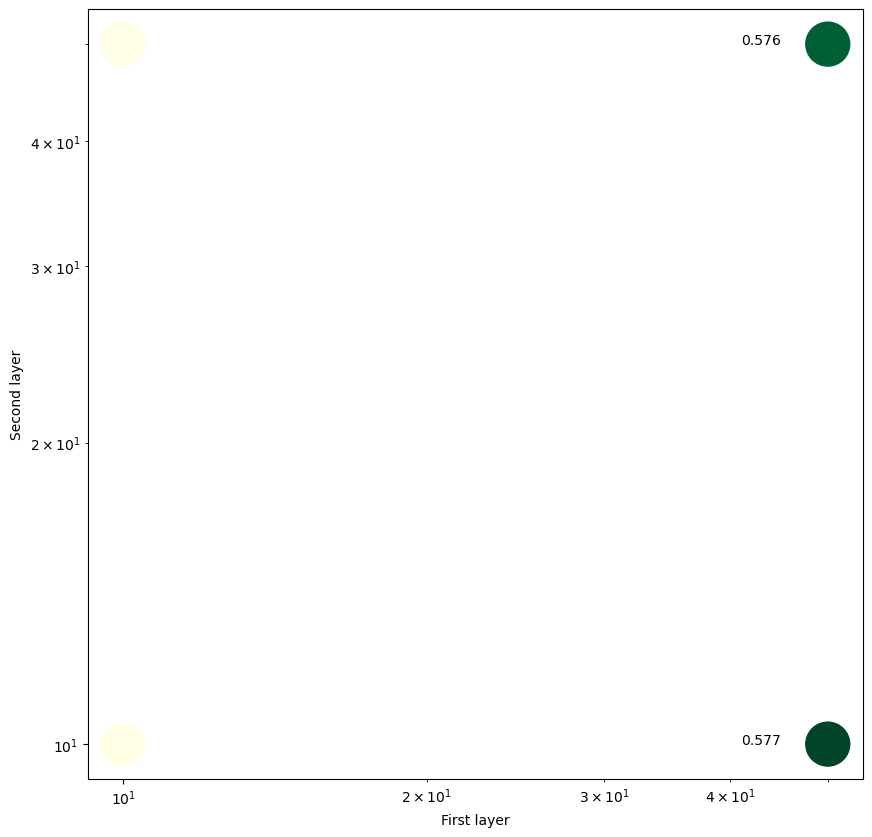

In [47]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(results["first"], results["second"], c=np.exp(results.acc*100), cmap="YlGn", s=1000)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("First layer")
plt.ylabel("Second layer")
for idx, row in results.iterrows():
    ax.annotate(str(row.acc)[:5], (row["first"]*0.82, row["second"]))
plt.show()

In [48]:
class MNISTClassifier_parametrized_3(nn.Module):
    def __init__(self,size_1,size_2, size_3):
        super(MNISTClassifier_parametrized_3, self).__init__()
        self.layer1 = nn.Linear(28 * 28, size_1)
        self.act_1 =  nn.Tanh()
        self.layer2 = nn.Linear(size_1, size_2)
        self.act_2 = nn.Tanh()
        self.layer3 = nn.Linear(size_2, size_3)
        self.act_3 = nn.Tanh()
        self.layer4 = nn.Linear(size_3, 10)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = self.act_1(self.layer1(flattened))
        activation2 = self.act_2(self.layer2(activation1))
        activation3 = self.act_3(self.layer3(activation2))
        output = self.layer4(activation3)
        return output

## Sieć o większej liczbie warstw wymaga dłuższego treningu

Epoch 0


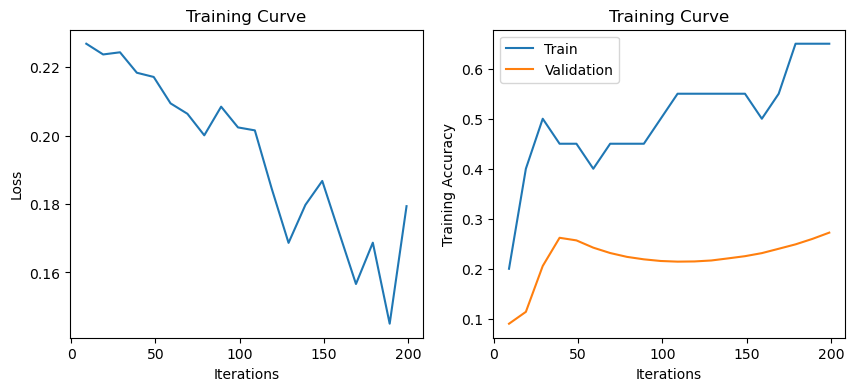

Final Training Accuracy: 0.65
Final Validation Accuracy: 0.2722444889779559


In [49]:
model = MNISTClassifier_parametrized_3(1000,500,100).to(device)
train(model, mnist_train, mnist_val, num_epochs=100)

Epoch 0


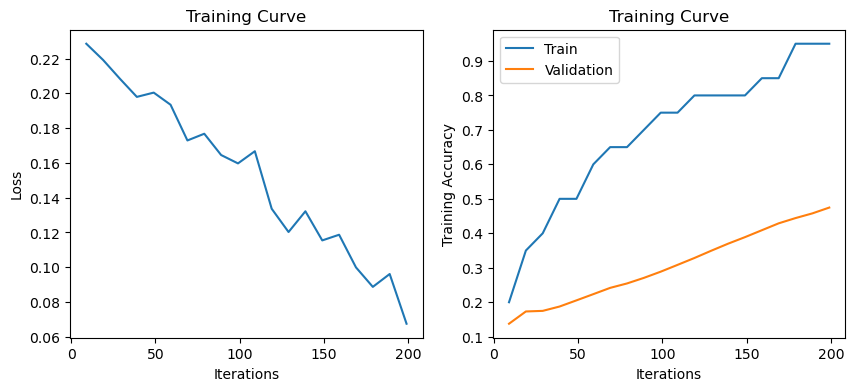

Final Training Accuracy: 0.95
Final Validation Accuracy: 0.4746492985971944


In [50]:
model = MNISTClassifier_parametrized(1000,500).to(device)
train(model, mnist_train, mnist_val, num_epochs=100)

## Większa liczba warstw może prowadzić do przeuczania

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900


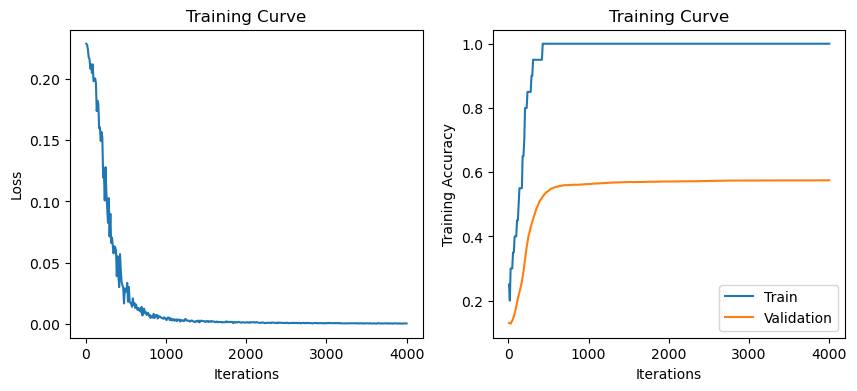

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5748496993987976


In [51]:
model = MNISTClassifier_parametrized_3(1000,500,100).to(device)
train(model, mnist_train, mnist_val, num_epochs=2000)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900


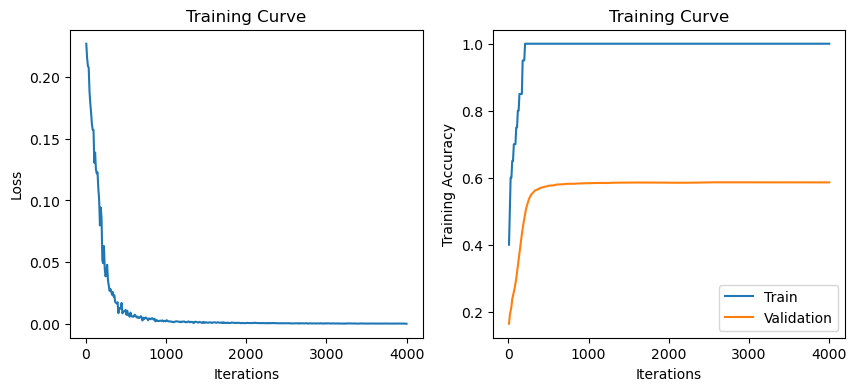

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5859719438877755


In [52]:
model = MNISTClassifier_parametrized(1000,500).to(device)
train(model, mnist_train, mnist_val, num_epochs=2000)

# Reprezentacja danych

In [53]:
adults_data_orig = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",header=None)

In [54]:
adults_data = adults_data_orig.copy()

In [55]:
adults_data.columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "label"]

In [56]:
adults_data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [57]:
adults_data.drop(columns=["native-country","education","workclass","relationship", "marital-status","race"],inplace=True)

In [58]:
adults_data

,age,fnlwgt,education-num,occupation,sex,capital-gain,capital-loss,hours-per-week,label
0,39,77516,13,Adm-clerical,Male,2174,0,40,<=50K
1,50,83311,13,Exec-managerial,Male,0,0,13,<=50K
2,38,215646,9,Handlers-cleaners,Male,0,0,40,<=50K
3,53,234721,7,Handlers-cleaners,Male,0,0,40,<=50K
4,28,338409,13,Prof-specialty,Female,0,0,40,<=50K
...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,Tech-support,Female,0,0,38,<=50K
32557,40,154374,9,Machine-op-inspct,Male,0,0,40,>50K
32558,58,151910,9,Adm-clerical,Female,0,0,40,<=50K
32559,22,201490,9,Adm-clerical,Male,0,0,20,<=50K


### Get dummies

In [59]:
adults_data.sex = (adults_data.sex==' Male').astype(int)
adults_data.label = (adults_data.label==' >50K').astype(int)

In [60]:
categorical_columns = ["occupation"]
categorical_values = pd.get_dummies(adults_data[categorical_columns])
categorical_values.head()

,occupation_ ?,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [61]:
adults_data.drop(columns=categorical_columns,inplace=True)

In [62]:
train_indices = np.random.rand(len(adults_data))>0.3

In [63]:
numerical_data = torch.from_numpy(adults_data.values[train_indices,:-1]).float()
categorical_data = torch.from_numpy(categorical_values.values[train_indices]).float()
targets = torch.from_numpy(adults_data.values[train_indices,-1]).float()

test_numerical_data = torch.from_numpy(adults_data.values[~train_indices,:-1]).float()
test_categorical_data = torch.from_numpy(categorical_values.values[~train_indices]).float()
test_targets = torch.from_numpy(adults_data.values[~train_indices,-1]).float()

In [64]:
train_dataset = data.TensorDataset(numerical_data,categorical_data,targets)
test_dataset = data.TensorDataset(test_numerical_data,test_categorical_data,test_targets)

### Cat numerical and categorical data

In [65]:
class Adults_classifier(nn.Module):
    def __init__(self):
        super(Adults_classifier, self).__init__()
        self.layer1 = nn.Linear(adults_data.shape[1] + categorical_data.shape[1] -1, 40)
        self.act_1 = nn.LeakyReLU()
        self.d1 = nn.Dropout(0.4)
        self.layer2 = nn.Linear(40, 20)
        self.act_2 = nn.LeakyReLU()
        self.d2 = nn.Dropout(0.4)
        self.layer3 = nn.Linear(20, 1)
    def forward(self, x, cat_x):
        x = torch.cat([x,cat_x],dim=1)
        activation1 = self.act_1(self.layer1(x))
        activation1 = self.d1(activation1)
        activation2 = self.act_2(self.layer2(activation1))
        activation2 = self.d1(activation2)
        output = self.layer3(activation2)
        return output

In [66]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    model.eval() #*********#
    for x, cat_x, labels in data_loader:
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        output = model(x, cat_x)
        pred = output>0
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += x.shape[0]
    return correct / total

In [67]:
model = Adults_classifier().to(device)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

iters = []
losses = []
train_acc = []
val_acc = []
for n in range(10):
    epoch_losses = []
    for x, cat_x, labels in iter(train_loader):
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        model.train()
        out = model(x, cat_x).squeeze()

        loss = criterion(out, labels)
        loss.backward()
        epoch_losses.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()

    loss_mean = np.array(epoch_losses).mean()
    iters.append(n)
    losses.append(loss_mean)
    test_acc = get_accuracy(model, test_loader)
    print(f"Epoch {n} loss {loss_mean:.3} test_acc: {test_acc:.3}")
    train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
    val_acc.append(test_acc)  # compute validation accuracy


print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 0 loss 3.92e+02 test_acc: 0.758
Epoch 1 loss 16.5 test_acc: 0.758
Epoch 2 loss 9.31 test_acc: 0.758
Epoch 3 loss 6.12 test_acc: 0.758
Epoch 4 loss 4.13 test_acc: 0.758
Epoch 5 loss 3.03 test_acc: 0.758
Epoch 6 loss 2.24 test_acc: 0.758
Epoch 7 loss 1.53 test_acc: 0.758
Epoch 8 loss 1.16 test_acc: 0.758
Epoch 9 loss 0.945 test_acc: 0.759
Final Training Accuracy: 0.7619464379485384
Final Validation Accuracy: 0.7593984962406015


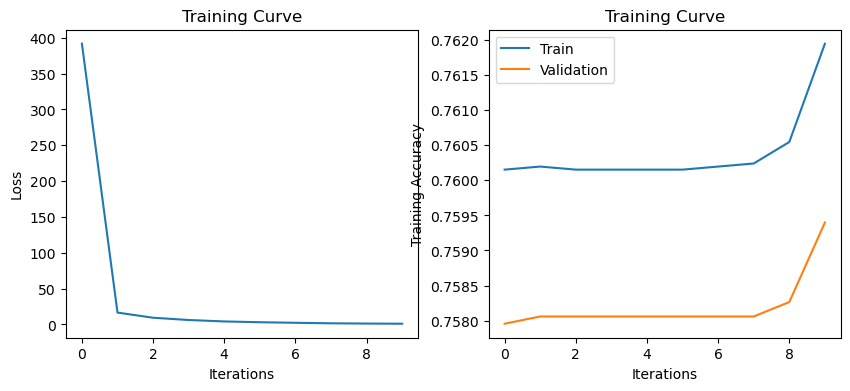

In [68]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.title("Training Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()

## Embeddingi, a później cat numerical i embedded

In [69]:
class Adults_classifier_embeddings(nn.Module):
    def __init__(self):
        super(Adults_classifier_embeddings, self).__init__()
        self.emb_layer = nn.Linear(categorical_data.shape[1], categorical_data.shape[1])
        self.act_emb = nn.Tanh()
        self.layer1 = nn.Linear(adults_data.shape[1] -1 + categorical_data.shape[1], 40)
        self.act_1 =  nn.LeakyReLU()
        self.d1 = nn.Dropout(0.4)
        self.layer2 = nn.Linear(40, 20)
        self.act_2 =  nn.LeakyReLU()
        self.d2 = nn.Dropout(0.4)
        self.layer3 = nn.Linear(20, 1)
    def forward(self, x, cat_x):
        cat_x_embedded = self.emb_layer(cat_x)
        cat_x_embedded = self.act_emb(cat_x_embedded)
        x = torch.cat([x,cat_x_embedded],dim=1)
        activation1 = self.act_1(self.layer1(x))
        activation1 = self.d1(activation1)
        activation2 = self.act_2(self.layer2(activation1))
        activation2 = self.d2(activation2)
        output = self.layer3(activation2)
        return output

In [70]:
model = Adults_classifier_embeddings().to(device)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

iters = []
losses = []
train_acc = []
val_acc = []
for n in range(10):
    epoch_losses = []
    for x, cat_x, labels in iter(train_loader):
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        model.train()
        out = model(x, cat_x).squeeze()

        loss = criterion(out, labels)
        loss.backward()
        epoch_losses.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()

    loss_mean = np.array(epoch_losses).mean()
    iters.append(n)
    losses.append(loss_mean)
    test_acc = get_accuracy(model, test_loader)
    print(f"Epoch {n} loss {loss_mean:.3} test_acc: {test_acc:.3}")
    train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
    val_acc.append(test_acc)  # compute validation accuracy


print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 0 loss 2.22e+02 test_acc: 0.76
Epoch 1 loss 13.9 test_acc: 0.759
Epoch 2 loss 8.43 test_acc: 0.76
Epoch 3 loss 5.32 test_acc: 0.761
Epoch 4 loss 3.64 test_acc: 0.763
Epoch 5 loss 2.39 test_acc: 0.764
Epoch 6 loss 1.64 test_acc: 0.766
Epoch 7 loss 1.11 test_acc: 0.766
Epoch 8 loss 0.845 test_acc: 0.765
Epoch 9 loss 0.712 test_acc: 0.765
Final Training Accuracy: 0.7663224225450727
Final Validation Accuracy: 0.764857348851581


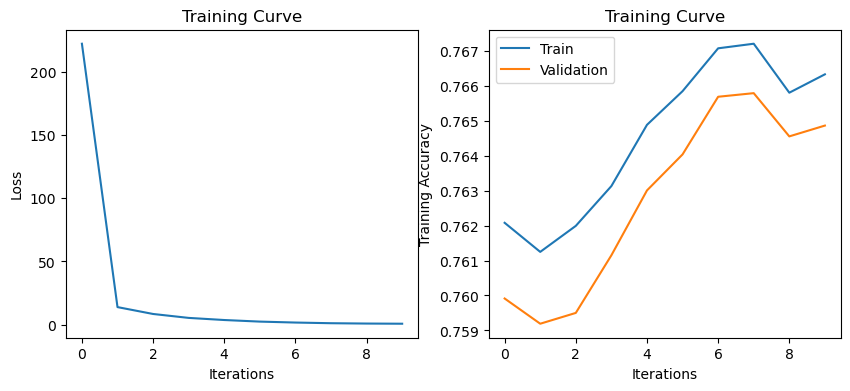

In [71]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.title("Training Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()

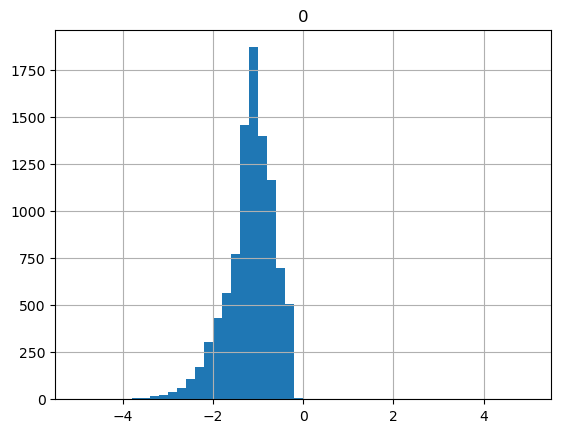

In [72]:
preds = model(test_numerical_data.to(device),test_categorical_data.to(device))
pd.DataFrame(preds.cpu().detach().numpy()).hist(bins=50, range=(-5,5));

In [73]:
(preds>0).sum()

tensor(71)

# Ważenie przykładów

In [74]:
model = Adults_classifier_embeddings().to(device)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
criterion = nn.BCEWithLogitsLoss(pos_weight=(len(targets)-sum(targets))/sum(targets))
optimizer = optim.Adam(model.parameters(), lr=0.001)

iters = []
losses = []
train_acc = []
val_acc = []
for n in range(30):
    epoch_losses = []
    for x, cat_x, labels in iter(train_loader):
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        model.train()
        out = model(x, cat_x).squeeze()

        loss = criterion(out, labels)
        loss.backward()
        epoch_losses.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()

    loss_mean = np.array(epoch_losses).mean()
    iters.append(n)
    losses.append(loss_mean)
    test_acc = get_accuracy(model, test_loader)
    print(f"Epoch {n} loss {loss_mean:.3} test_acc: {test_acc:.3}")
    train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
    val_acc.append(test_acc)  # compute validation accuracy


print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 0 loss 3.7e+02 test_acc: 0.775
Epoch 1 loss 18.1 test_acc: 0.242
Epoch 2 loss 11.0 test_acc: 0.343
Epoch 3 loss 6.37 test_acc: 0.242
Epoch 4 loss 3.98 test_acc: 0.773
Epoch 5 loss 2.7 test_acc: 0.242
Epoch 6 loss 1.83 test_acc: 0.782
Epoch 7 loss 1.45 test_acc: 0.27
Epoch 8 loss 1.33 test_acc: 0.44
Epoch 9 loss 1.24 test_acc: 0.797
Epoch 10 loss 1.18 test_acc: 0.58
Epoch 11 loss 1.14 test_acc: 0.79
Epoch 12 loss 1.12 test_acc: 0.725
Epoch 13 loss 1.08 test_acc: 0.786
Epoch 14 loss 1.08 test_acc: 0.786
Epoch 15 loss 1.08 test_acc: 0.792
Epoch 16 loss 1.04 test_acc: 0.416
Epoch 17 loss 1.07 test_acc: 0.411
Epoch 18 loss 1.08 test_acc: 0.469
Epoch 19 loss 1.04 test_acc: 0.293
Epoch 20 loss 1.02 test_acc: 0.792
Epoch 21 loss 1.0 test_acc: 0.794
Epoch 22 loss 0.999 test_acc: 0.418
Epoch 23 loss 0.993 test_acc: 0.785
Epoch 24 loss 0.995 test_acc: 0.794
Epoch 25 loss 0.985 test_acc: 0.795
Epoch 26 loss 0.992 test_acc: 0.795
Epoch 27 loss 0.992 test_acc: 0.797
Epoch 28 loss 0.978 test_ac

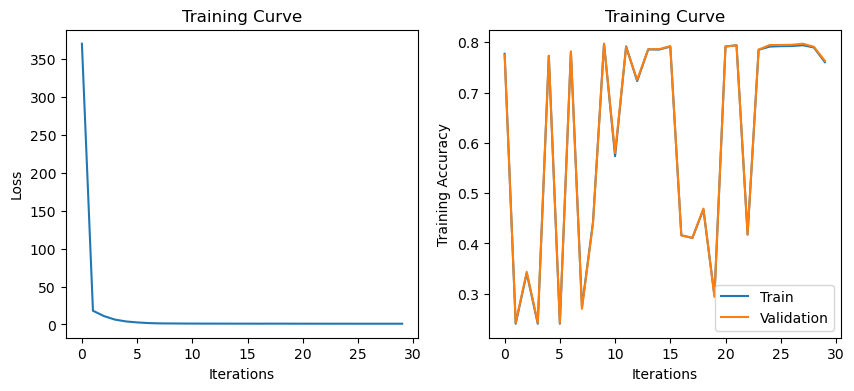

In [75]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.title("Training Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()

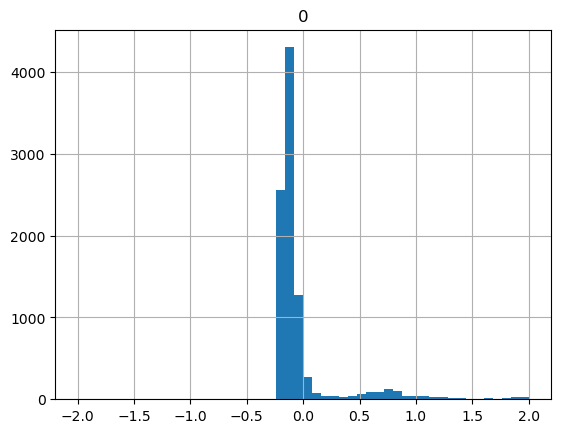

In [76]:
preds = model(test_numerical_data.to(device),test_categorical_data.to(device))
pd.DataFrame(preds.cpu().detach().numpy()).hist(bins=50, range=(-2,2));

In [77]:
(preds>0).sum()

tensor(1573)